In [9]:
! pip install numpy tensorflow keras scikit-learn pandas -qq

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

In [25]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
! wget {url} -O smsspamcollection.zip
! unzip smsspamcollection.zip

--2024-05-17 10:58:13--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z     [   <=>              ] 198.65K   385KB/s    in 0.5s    

2024-05-17 10:58:14 (385 KB/s) - ‘smsspamcollection.zip’ saved [203415]

Archive:  smsspamcollection.zip
replace SMSSpamCollection? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [42]:
data = pd.read_csv('SMSSpamCollection', sep='\t', names=['Label', 'SMS'])
data

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [63]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['SMS'])
X = tokenizer.texts_to_sequences(data['SMS'])
X = pad_sequences(X, maxlen=50)
X

array([[   0,    0,    0, ...,   58, 4437,  144],
       [   0,    0,    0, ...,  472,    6, 1940],
       [   0,    0,    0, ...,  660,  392, 2998],
       ...,
       [   0,    0,    0, ...,  107,  251, 9008],
       [   0,    0,    0, ...,  200,   12,   47],
       [   0,    0,    0, ...,    2,   61,  268]], dtype=int32)

In [64]:
le = LabelEncoder()
y = le.fit_transform(data['Label'])
y = np.array(y)
y

array([0, 0, 1, ..., 0, 0, 0])

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
model = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100, input_length=50),
    SpatialDropout1D(0.2),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid'),
])

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy'],
)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 100)           901000    
                                                                 
 spatial_dropout1d_3 (Spati  (None, 50, 100)           0         
 alDropout1D)                                                    
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 981501 (3.74 MB)
Trainable params: 981501 (3.74 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [47]:
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)

Epoch 1/5
63/63 [==============================] - 14s 163ms/step - loss: 0.6285 - accuracy: 0.8374 - val_loss: 0.4047 - val_accuracy: 0.8453
Epoch 2/5
63/63 [==============================] - 9s 136ms/step - loss: 0.3322 - accuracy: 0.8681 - val_loss: 0.3147 - val_accuracy: 0.8453
Epoch 3/5
63/63 [==============================] - 16s 257ms/step - loss: 0.2553 - accuracy: 0.8746 - val_loss: 0.2517 - val_accuracy: 0.9013
Epoch 4/5
63/63 [==============================] - 10s 158ms/step - loss: 0.2004 - accuracy: 0.9354 - val_loss: 0.2105 - val_accuracy: 0.9372
Epoch 5/5
63/63 [==============================] - 10s 155ms/step - loss: 0.1493 - accuracy: 0.9643 - val_loss: 0.1652 - val_accuracy: 0.9507


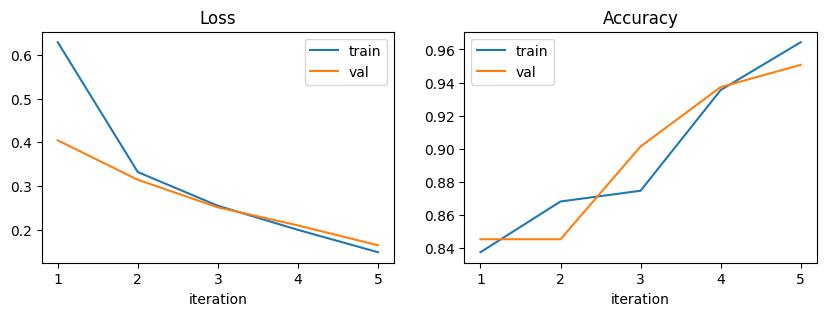

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

for i, (sfx, name) in enumerate(zip(['', 'val_'], ['train', 'val'])):
    loss = history.history[f'{sfx}loss']
    acc = history.history[f'{sfx}accuracy']
    ax1.plot(list(range(1, len(loss) + 1)), loss, label=name)
    ax2.plot(list(range(1, len(acc) + 1)), acc, label=name)

ax1.set_title('Loss')
ax2.set_title('Accuracy')

for ax in [ax1, ax2]:
    ax.legend()
    ax.set_xlabel('iteration')

In [61]:
y_pred = (model.predict(X_test) > 0.5).astype(int)

35/35 [==============================] - 1s 15ms/step


In [62]:
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'f1_score={f1:.4f}')

f1_score=0.9689
